# Titanic Data Set

In [1]:
# Import libraries we will need in the following
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics 
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from helpers_Garden import visualize_tree, plot_tree_interactive, randomized_tree_interactive
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report

import helpers_Garden as hg
from plottings import plot_learning_curve


# set plot size
plt.rcParams['figure.figsize'] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Read dataset

We are going to read a simple dataset.
This is the famous titanic dataset, you already met.

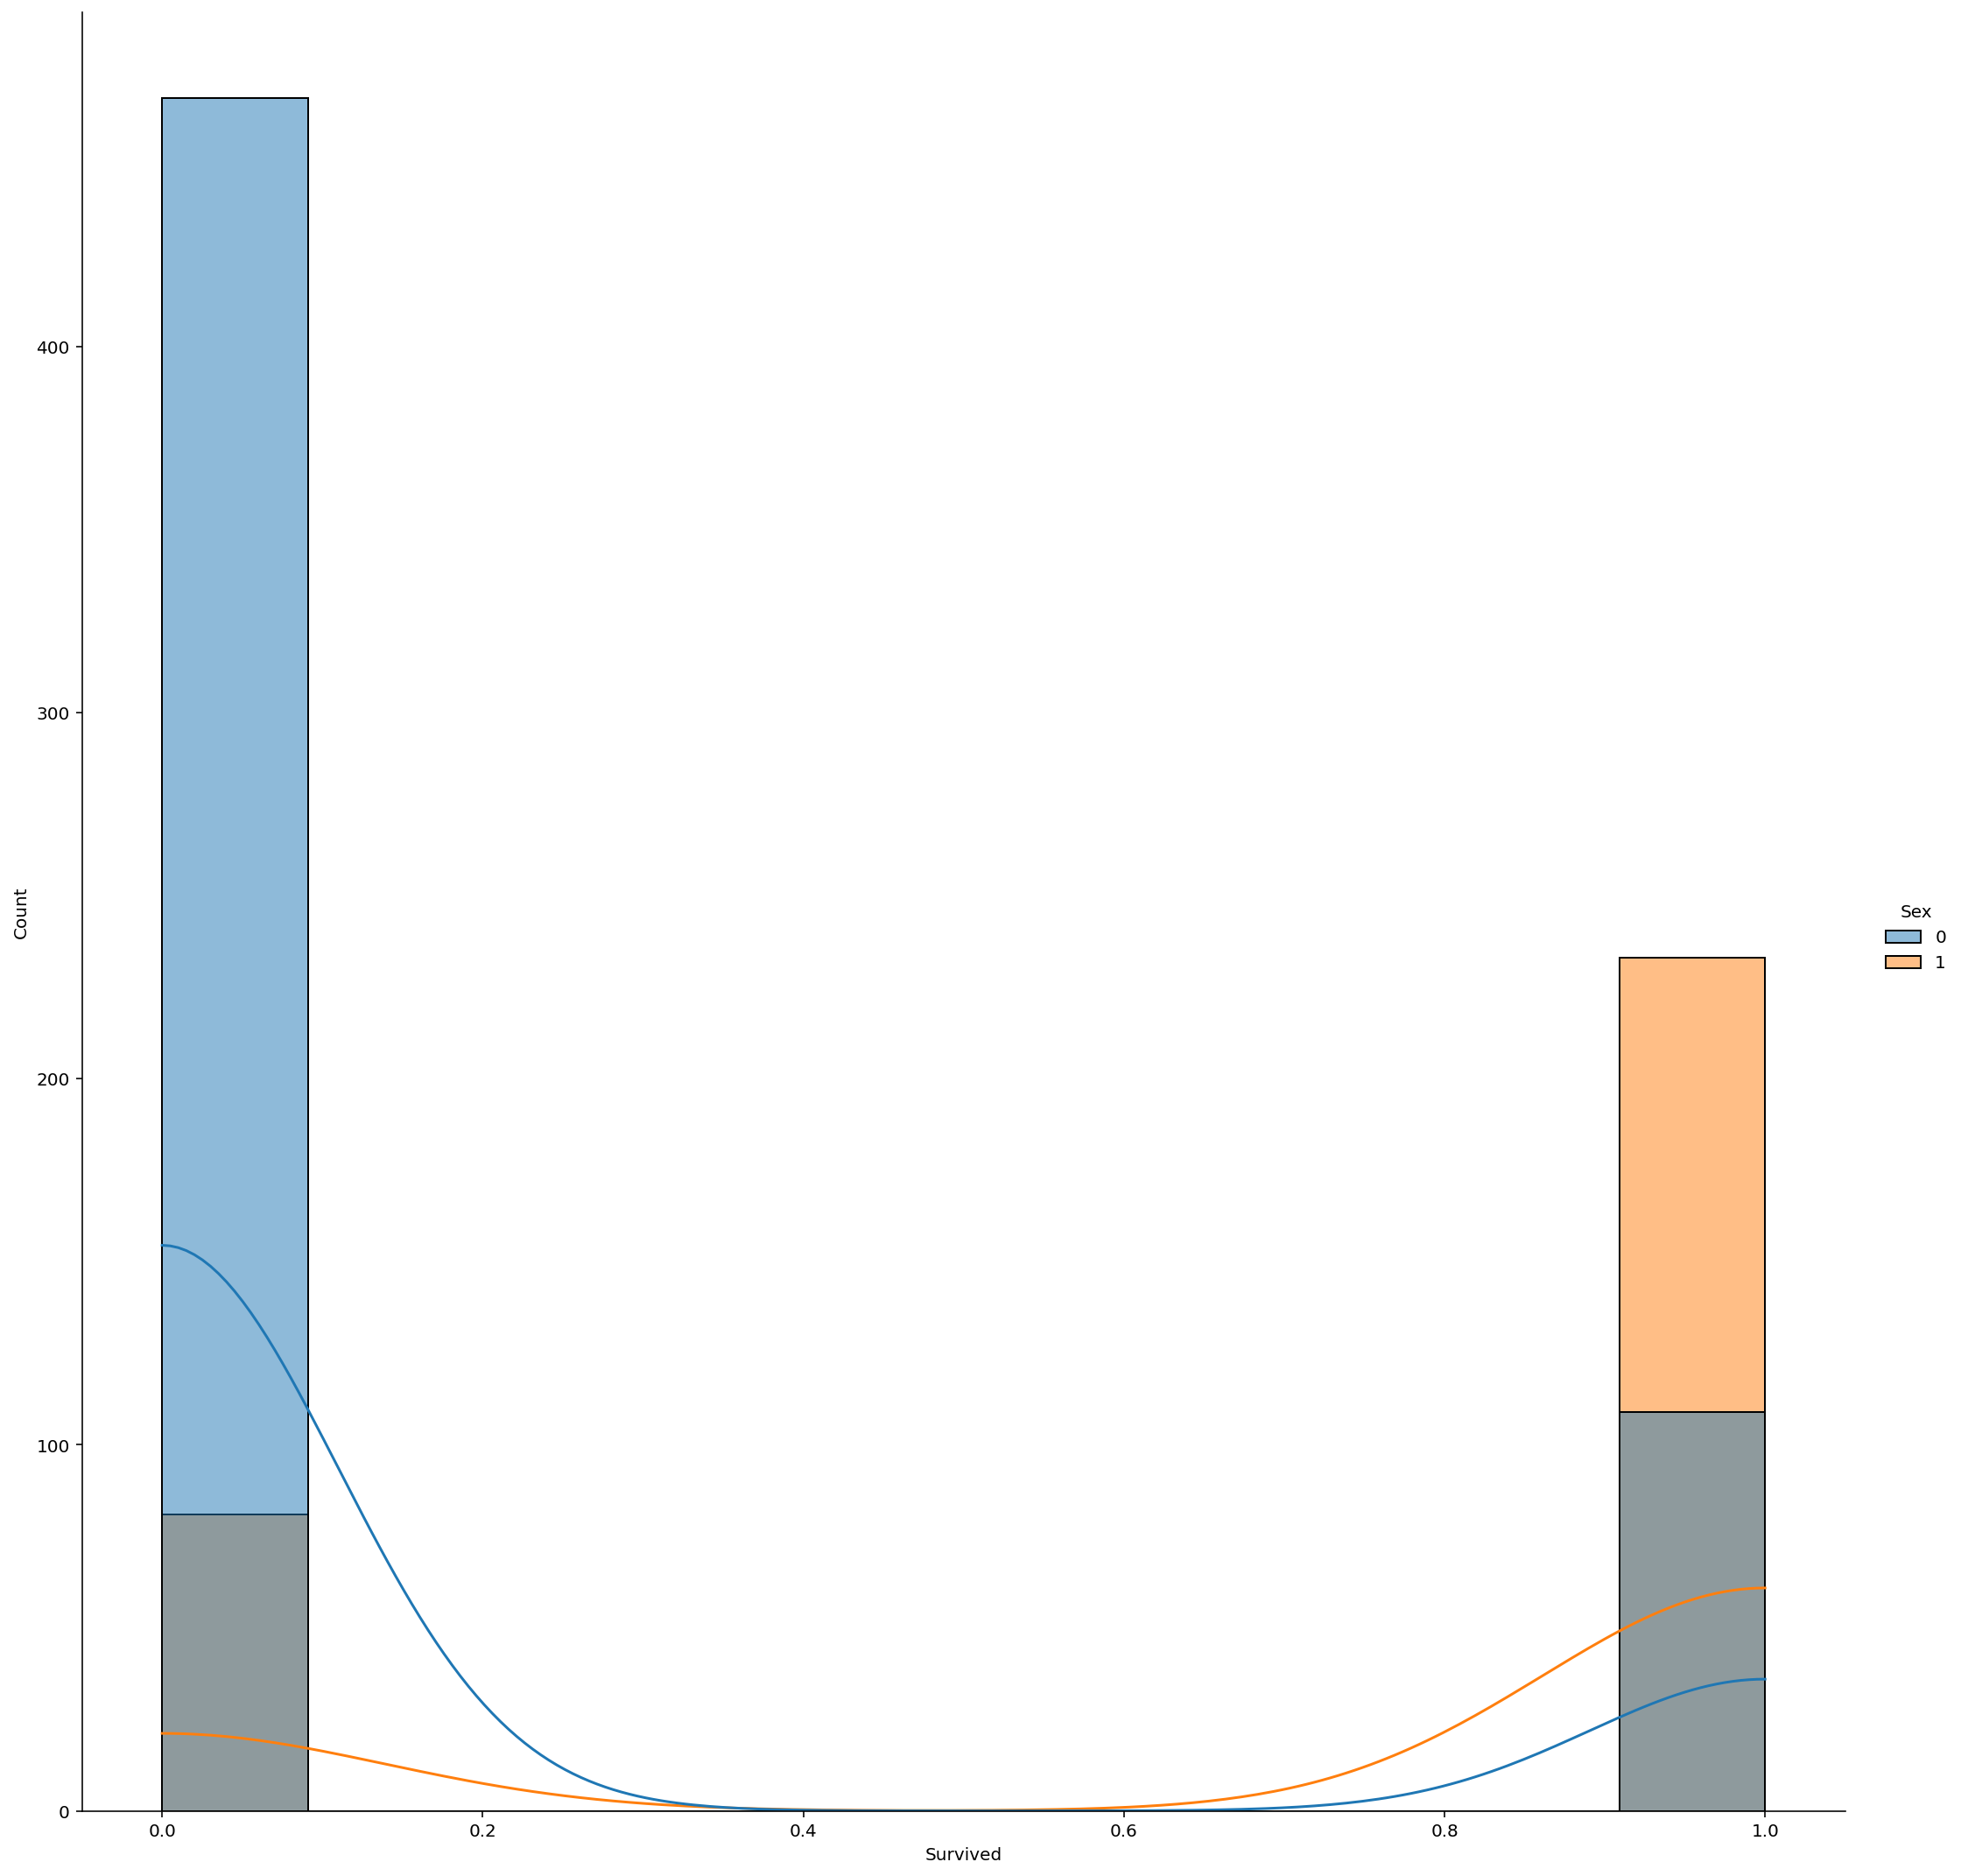

In [2]:
df = pd.read_csv('http://bit.ly/kaggletrain')
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

sns.displot(data=df, x="Survived", kde=True, hue="Sex", height=15);

In [3]:
features = ['Pclass', 'Fare', 'Sex', 'Parch']
X = df[features]
y = df['Survived']

### Train and test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### OUR WORK

In [6]:
#guardo come è fatto il dataset, se ci sono dati con un andamento lineare fra loro o poco correlati con la variabile target
#controllo anche se ci sono dati mancanti
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


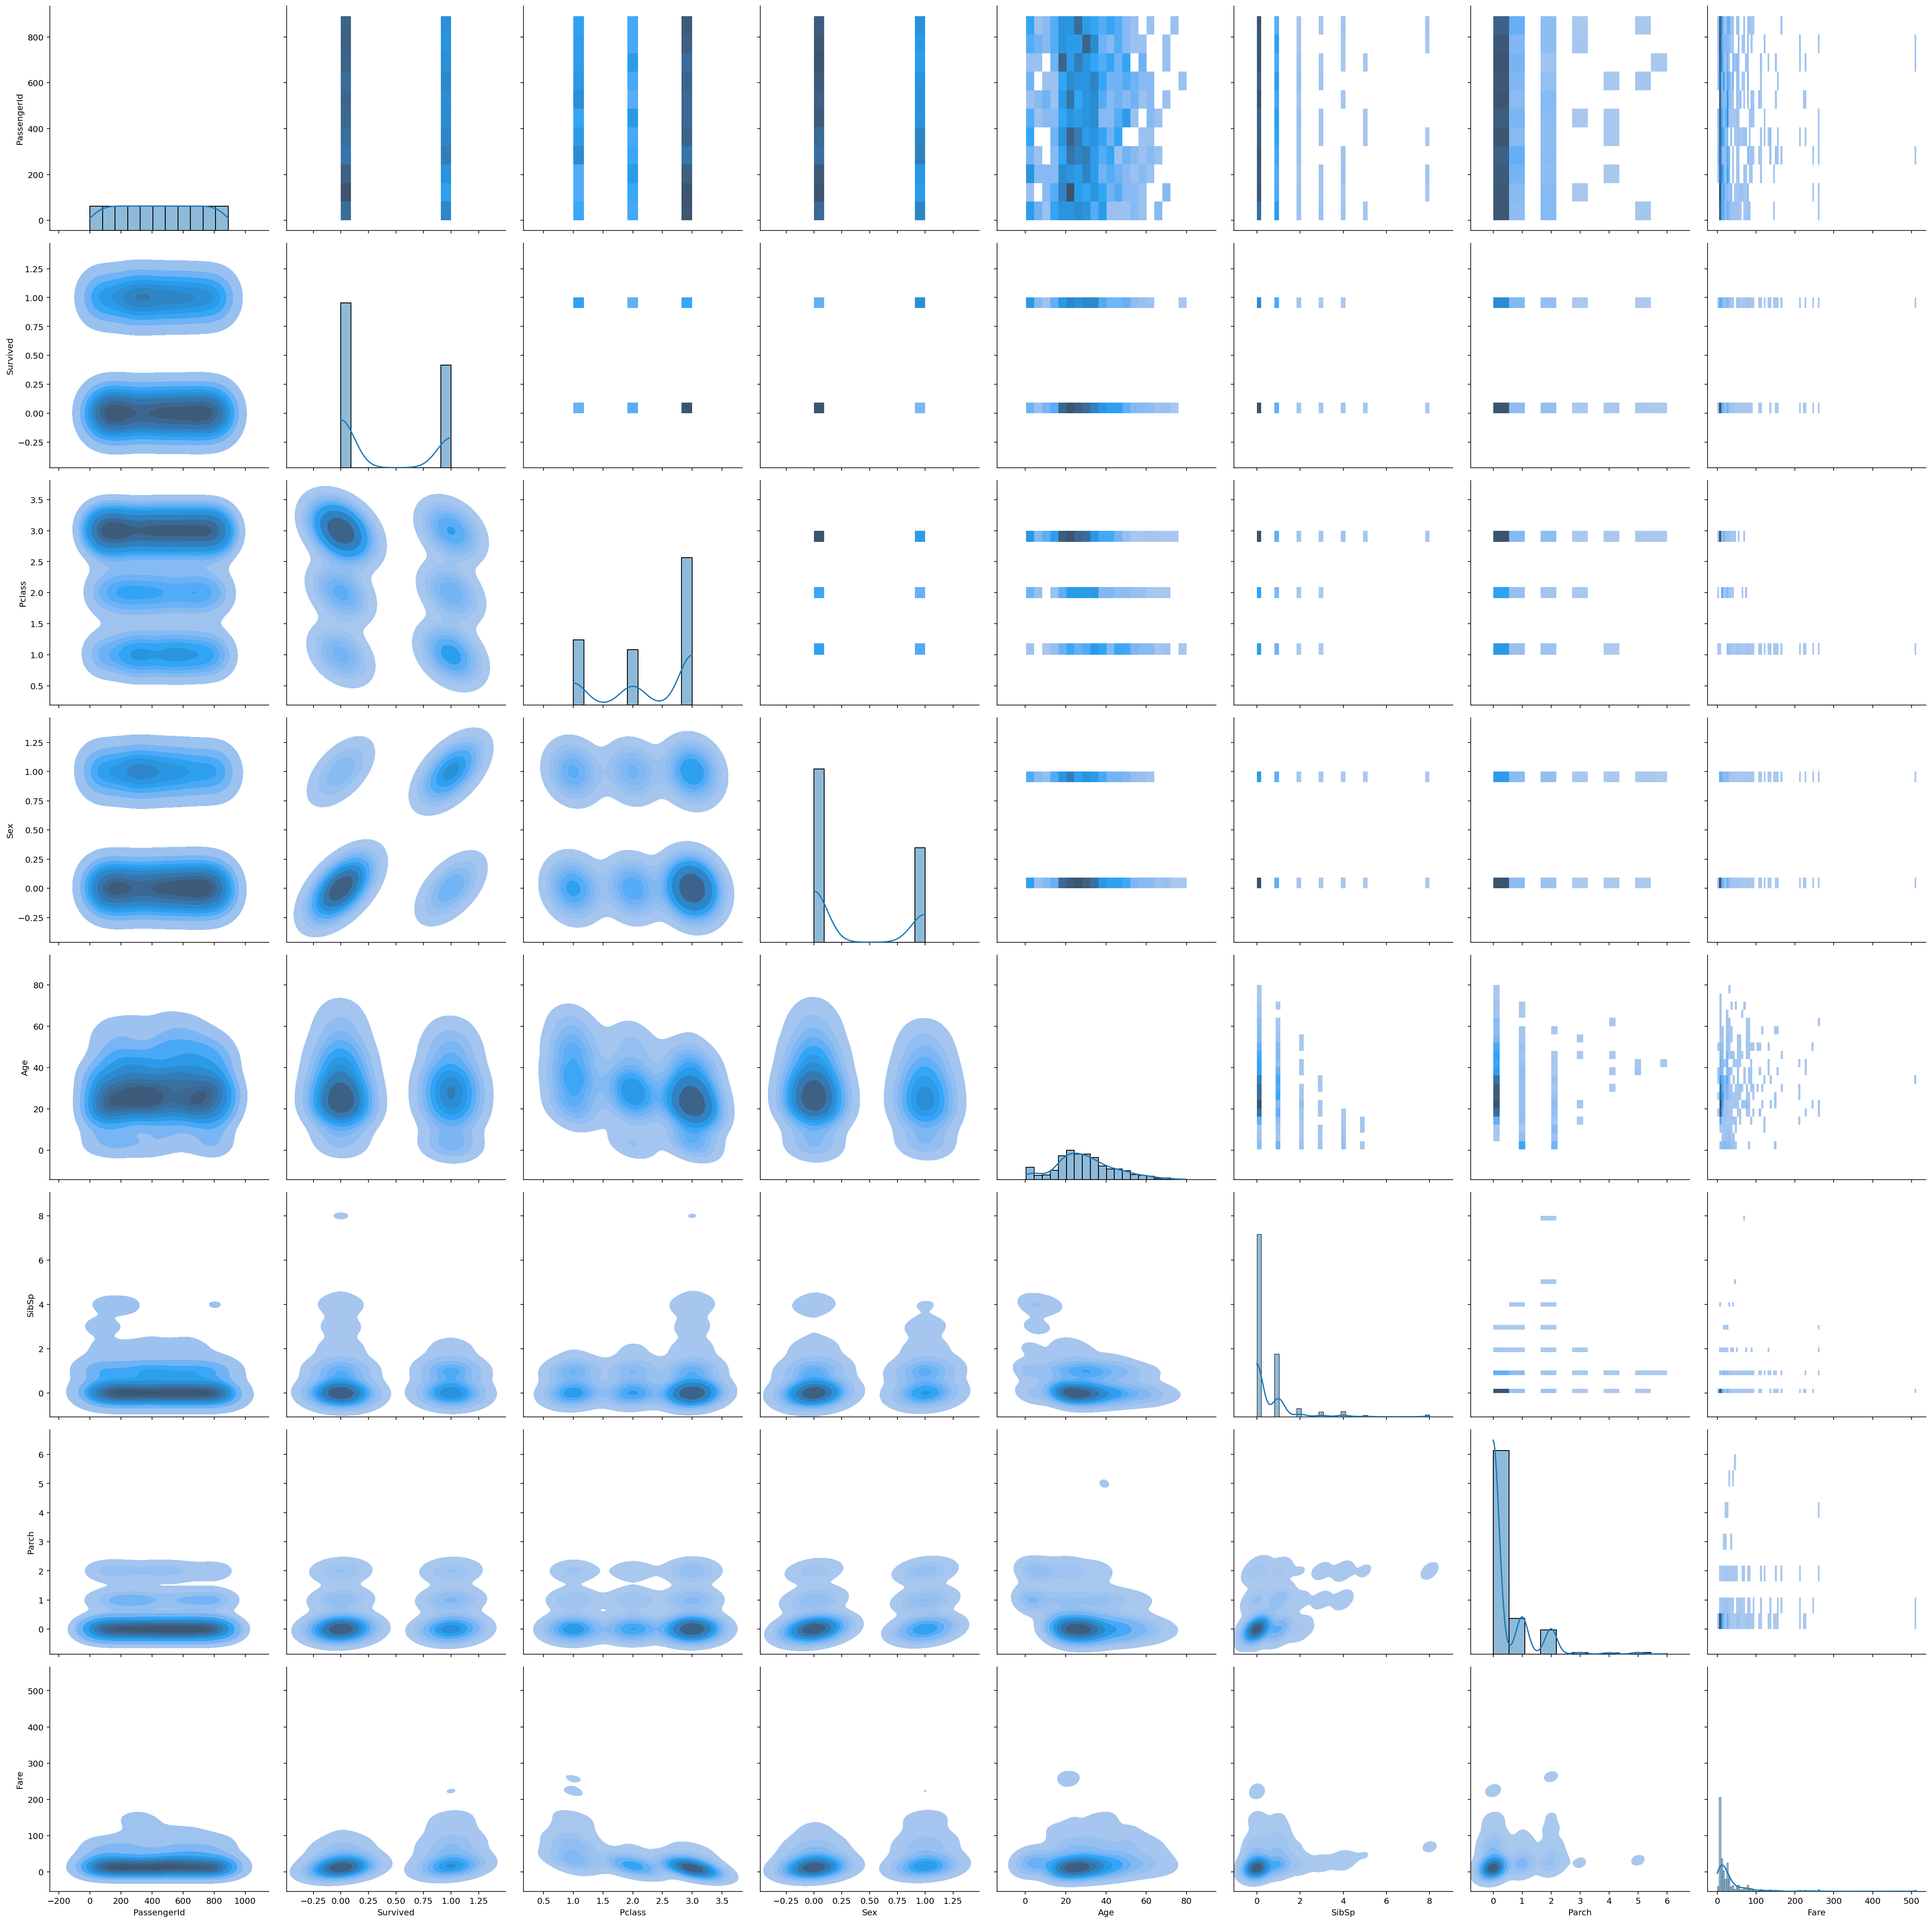

In [7]:
g = sns.PairGrid(df, height=4)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

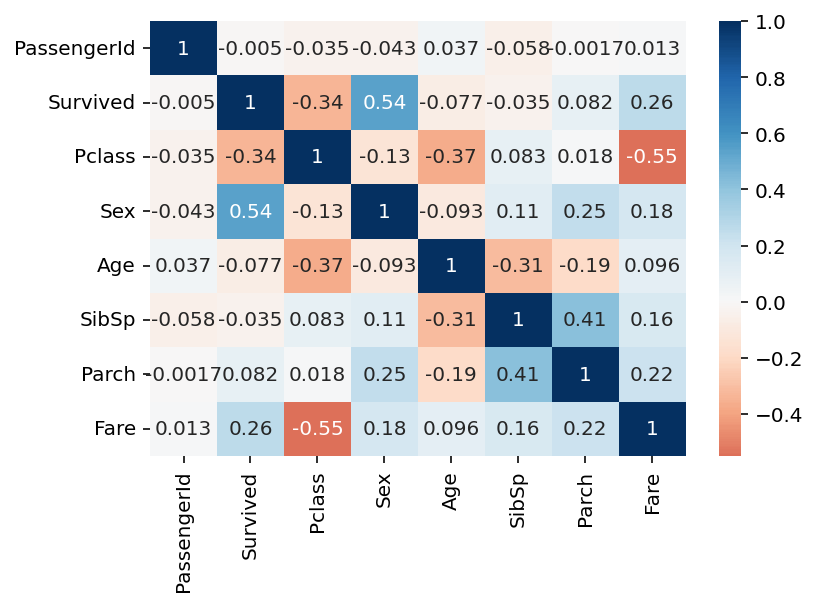

In [8]:
sns.heatmap(df.corr(), annot= True, cmap='RdBu', center=0)
plt.show()

Tengo le variabili più correlate. A giudicare solo dagli istogrammi avrei tenuto anche l'età, invece ha una correlazione bassissima, quindi si scarta anche quello.

In [9]:
df.duplicated().sum()

0

## creare il modello DecisionTreeClassifier

In [10]:
clf = DecisionTreeClassifier()

In [11]:
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [12]:
y_pred=clf.predict(X_test)

In [13]:
np.count_nonzero(y_pred == y_test)

144

In [14]:
# controllare l' Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)

Accuracy: 80.44692737430168


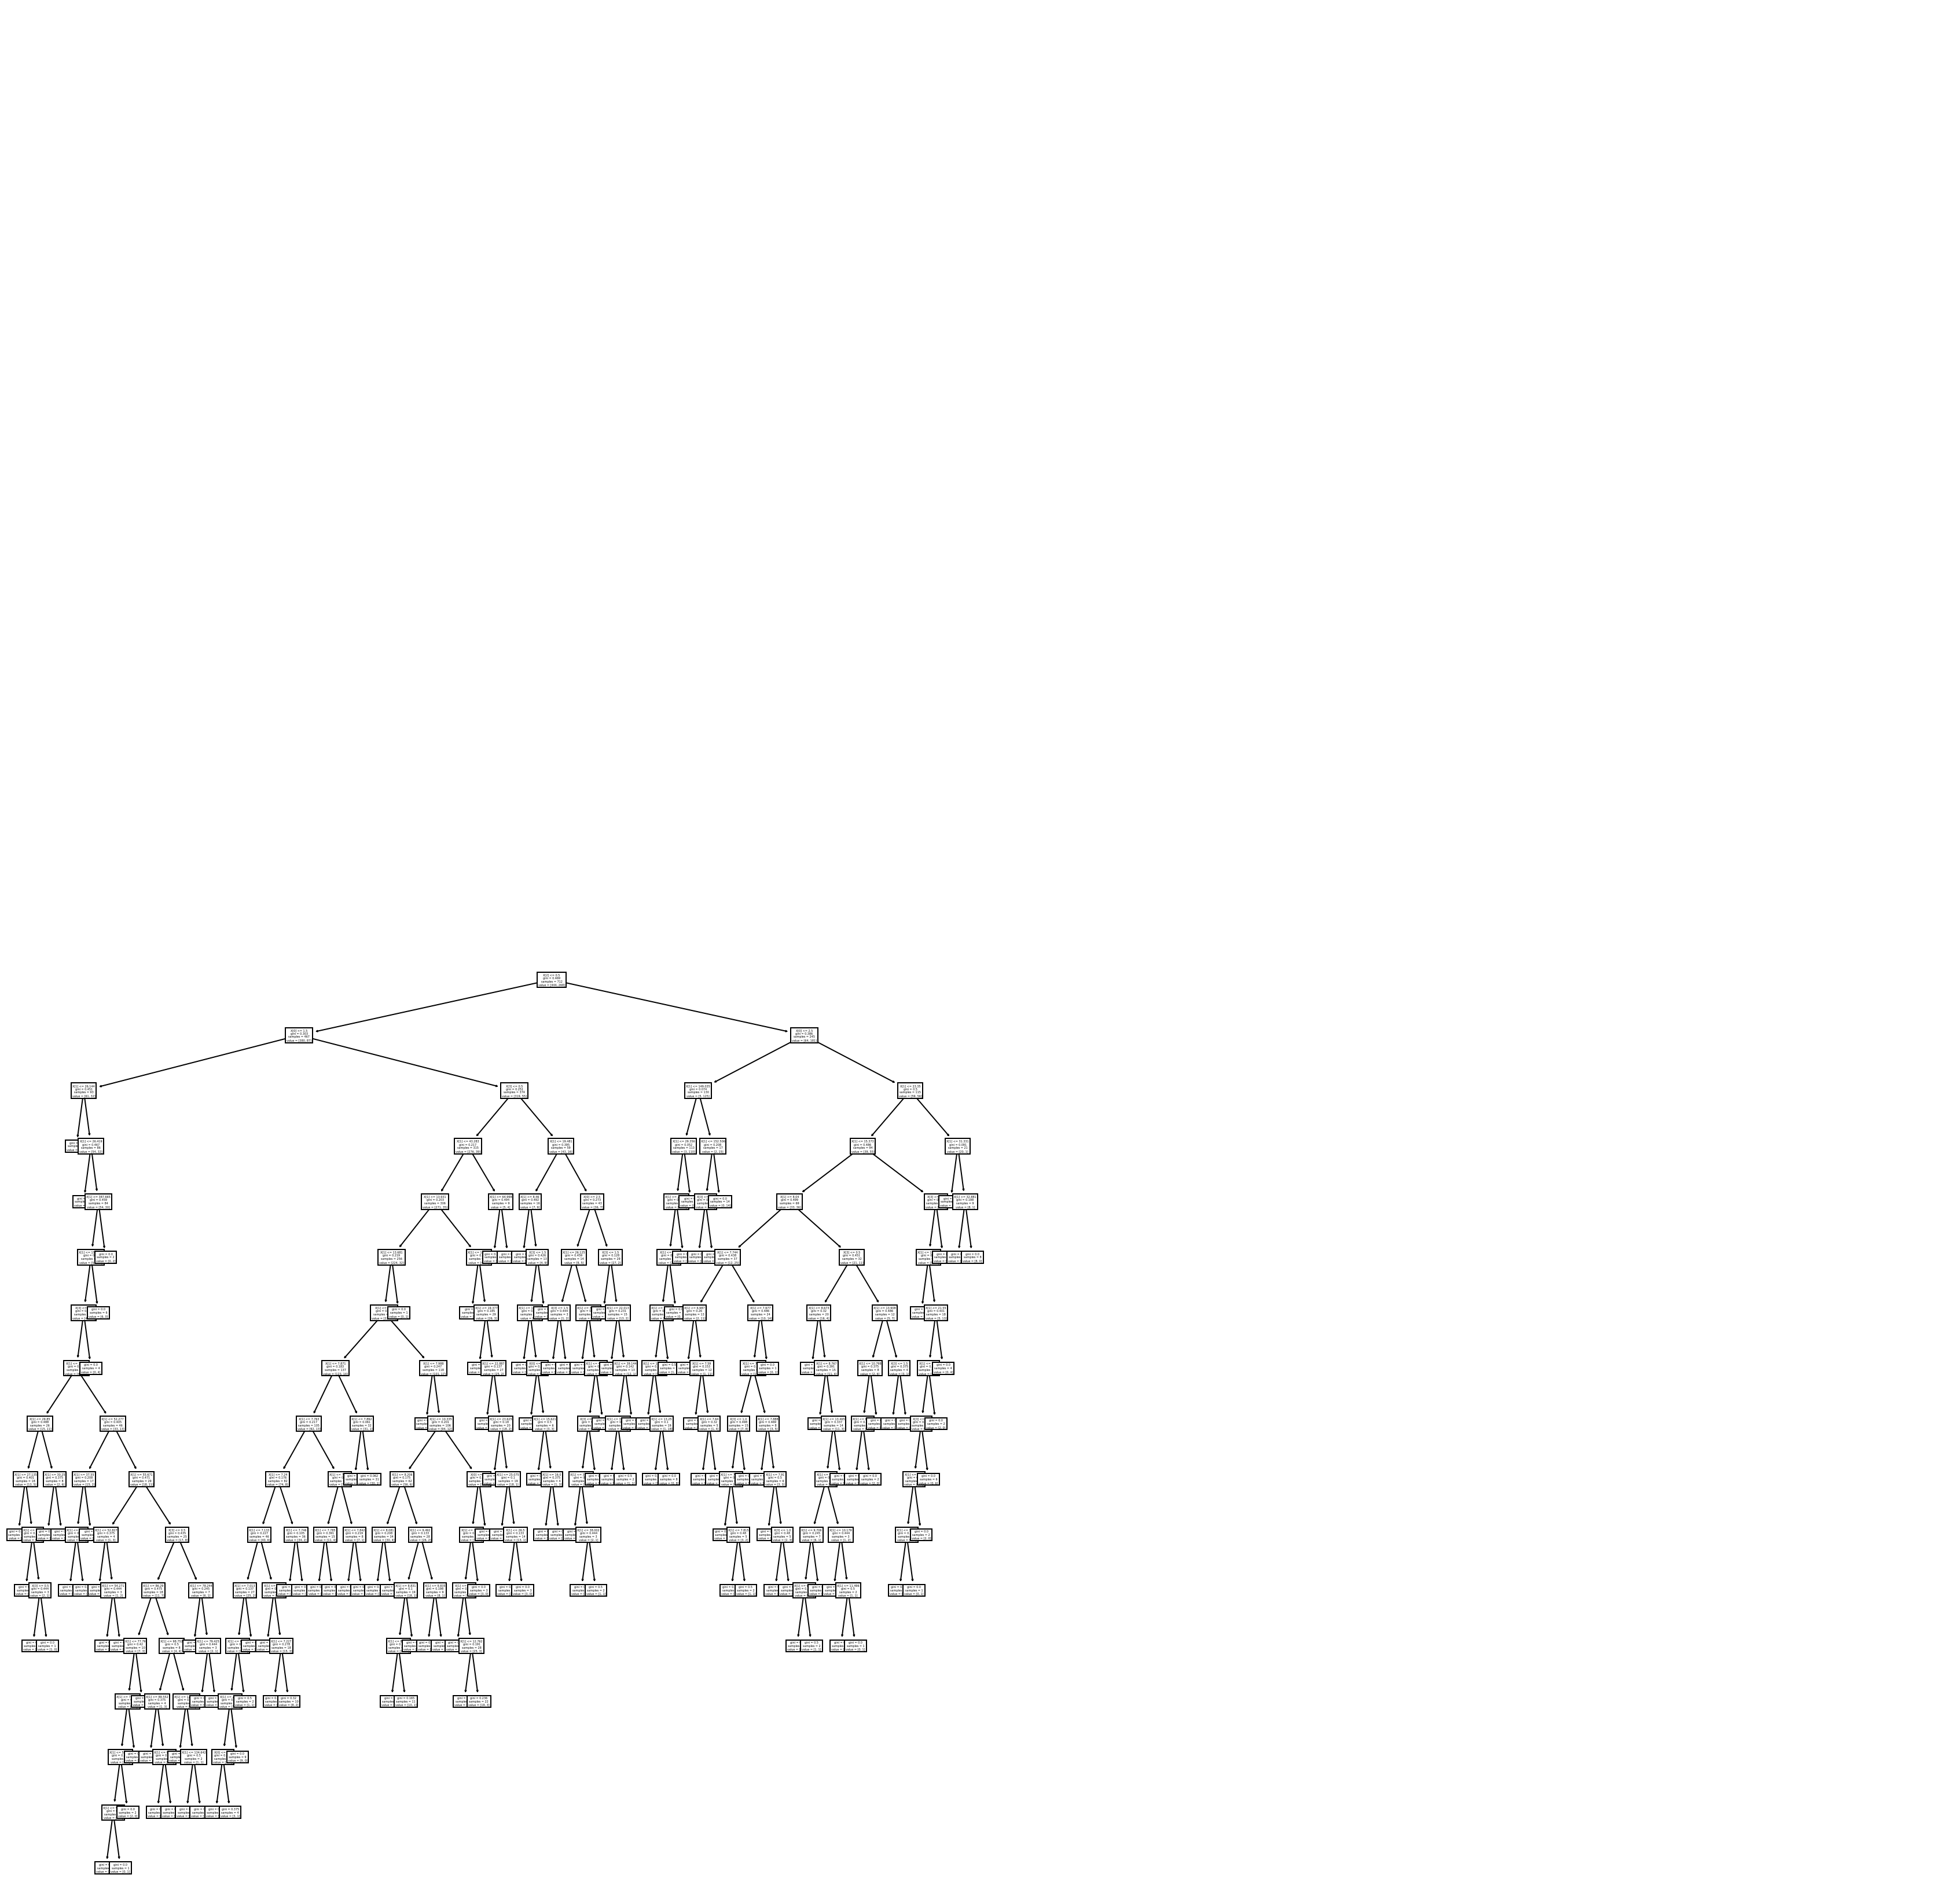

In [15]:
# la profondità dell'albero 
plt.figure(figsize=(30,30))
tree.plot_tree(clf);

## Uso la validation curve per vedere se il modello si può migliorare

In [16]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)
max_depth = [1, 2 ,3 ,4 ,5,6, 7, 15, 20, 25]
train_scores, test_scores = validation_curve(
    clf, X, y, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="f1", n_jobs=-1)

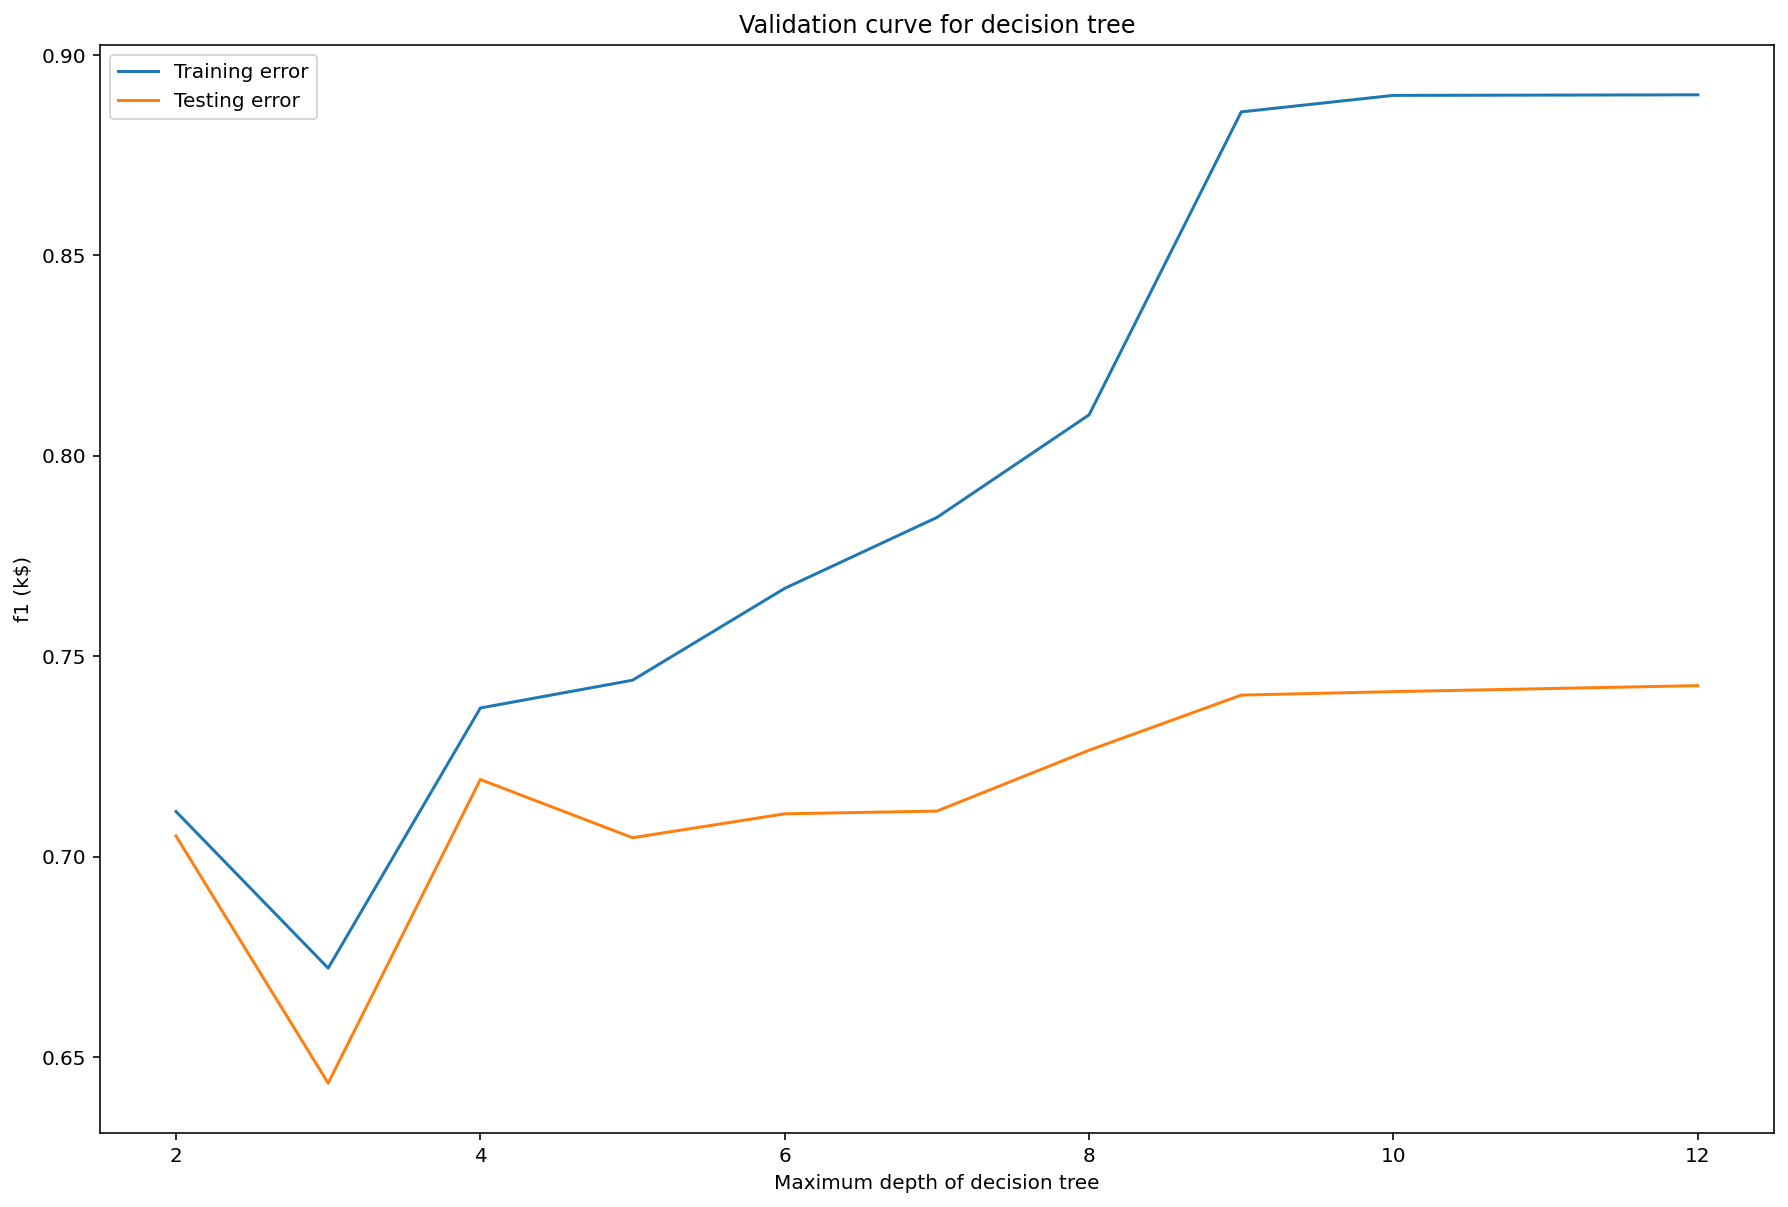

In [34]:
# plot validation curve 
plt.figure(figsize=(15,10))
plt.plot(max_depth, train_scores.mean(axis=1), label="Training error")
plt.plot(max_depth, test_scores.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("f1 (k$)")
plt.title("Validation curve for decision tree");

<module 'matplotlib.pyplot' from 'C:\\Users\\moham\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

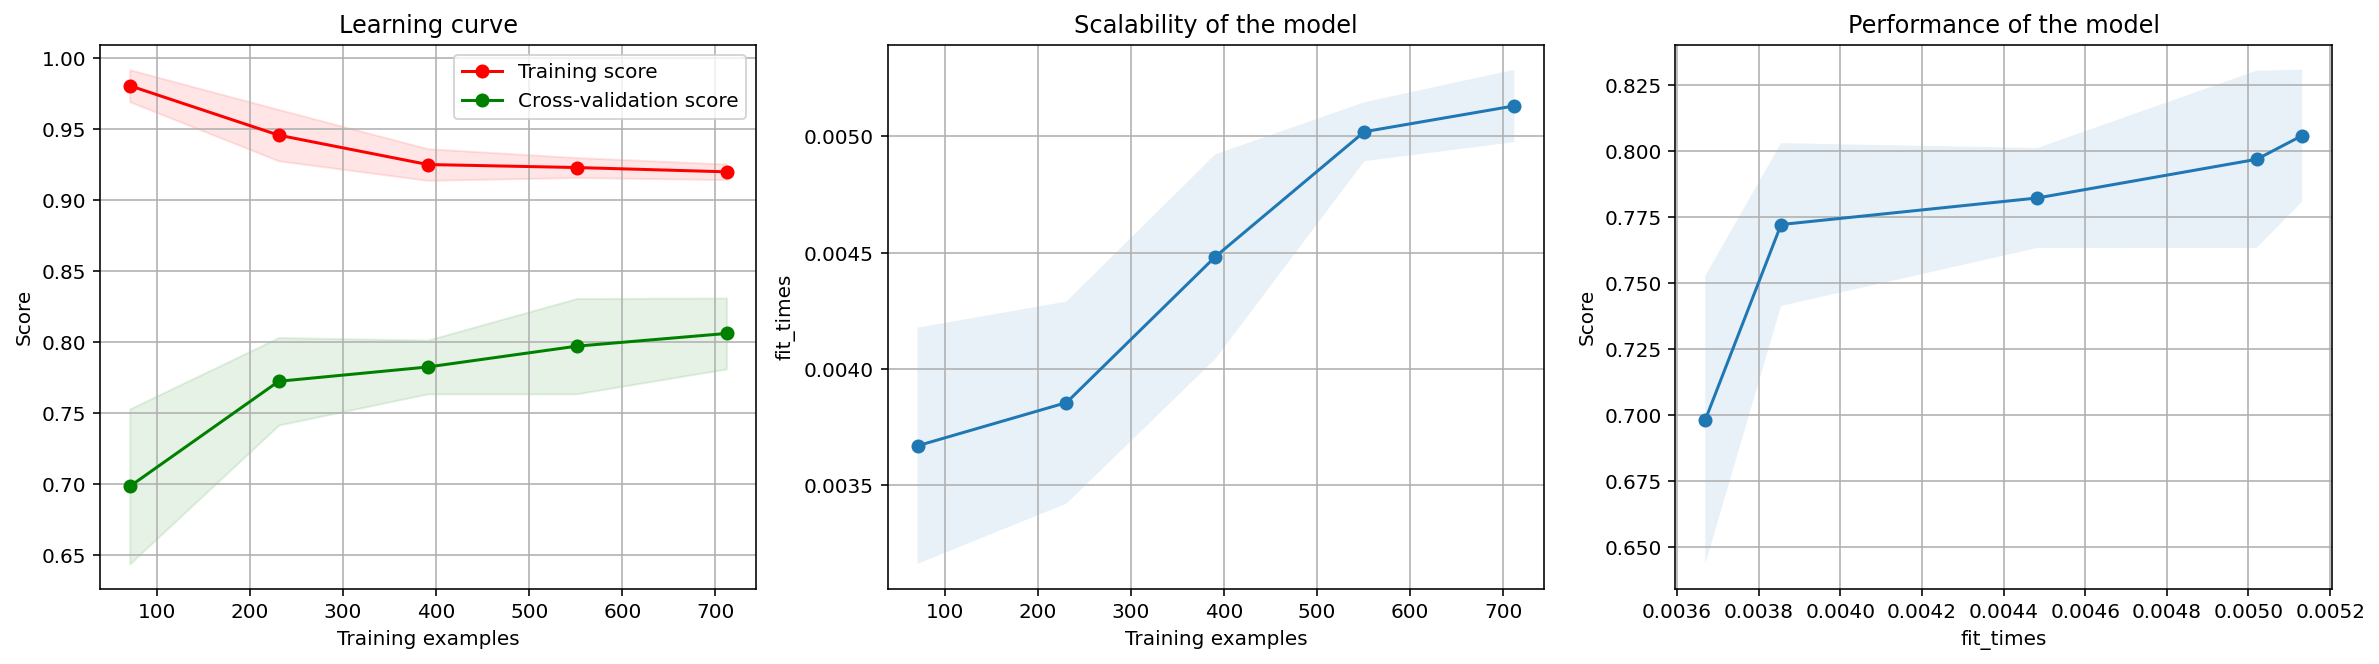

In [18]:
plot_learning_curve(clf, 'Learning curve', X, y)

* Mi aspetto che il miglior parametro per max_depth sia compreso fra 2 e 5

## Cercare i parametri migliori per il modello 

* Usiamo il GridSearch per trovare i parametri più performanti

In [19]:
pipe = Pipeline(steps=[('clf', clf)])

In [20]:
criterion = ['gini', 'entropy']
max_depth = [2,3,4,5,6,7,8,9,10,12]
max_leaf_nodes= [i for i in range(5,50)]

In [21]:
parameters = dict(clf__criterion=criterion,clf__max_depth=max_depth,clf__max_leaf_nodes=max_leaf_nodes)

* Scelgo come metrica l'f-score

clf score = 0.8212290502793296
clf best parameters = {'clf__criterion': 'gini', 'clf__max_depth': 12, 'clf__max_leaf_nodes': 48}


<AxesSubplot:xlabel='param_clf__criterion', ylabel='param_clf__max_depth'>

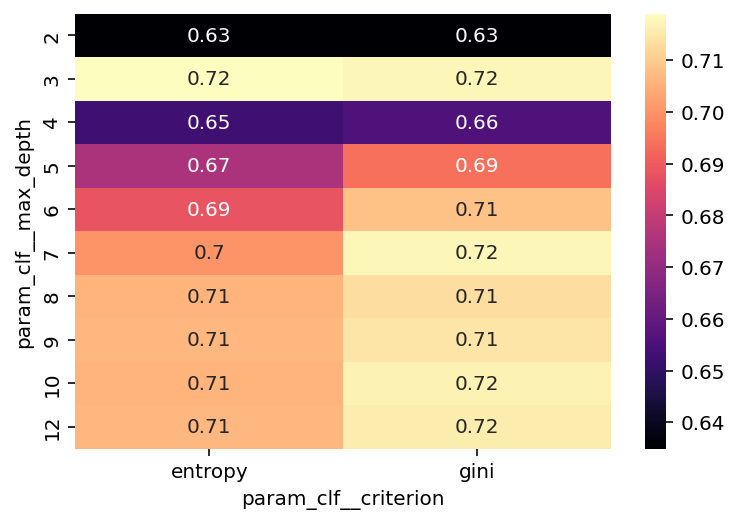

In [22]:
grid = GridSearchCV(pipe, parameters, scoring='f1') 
grid.fit(X_train,y_train)
print('clf score =', grid.best_estimator_.score(X_test, y_test))
print('clf best parameters =', grid.best_params_)

 

hmknn = pd.pivot_table(pd.DataFrame(grid.cv_results_),
                                    values='mean_test_score',
                                    index='param_clf__max_depth',
                                    columns='param_clf__criterion')

 

sns.heatmap(hmknn, cmap = 'magma', annot = True)

* Uso i parametri stimati

In [23]:
clf_try = DecisionTreeClassifier(max_depth=12,max_leaf_nodes=48,criterion='entropy')
clf_try.fit(X_train,y_train)
y_pred_try=clf_try.predict(X_test)

In [24]:
np.count_nonzero(y_pred_try == y_test)

146

<module 'matplotlib.pyplot' from 'C:\\Users\\moham\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

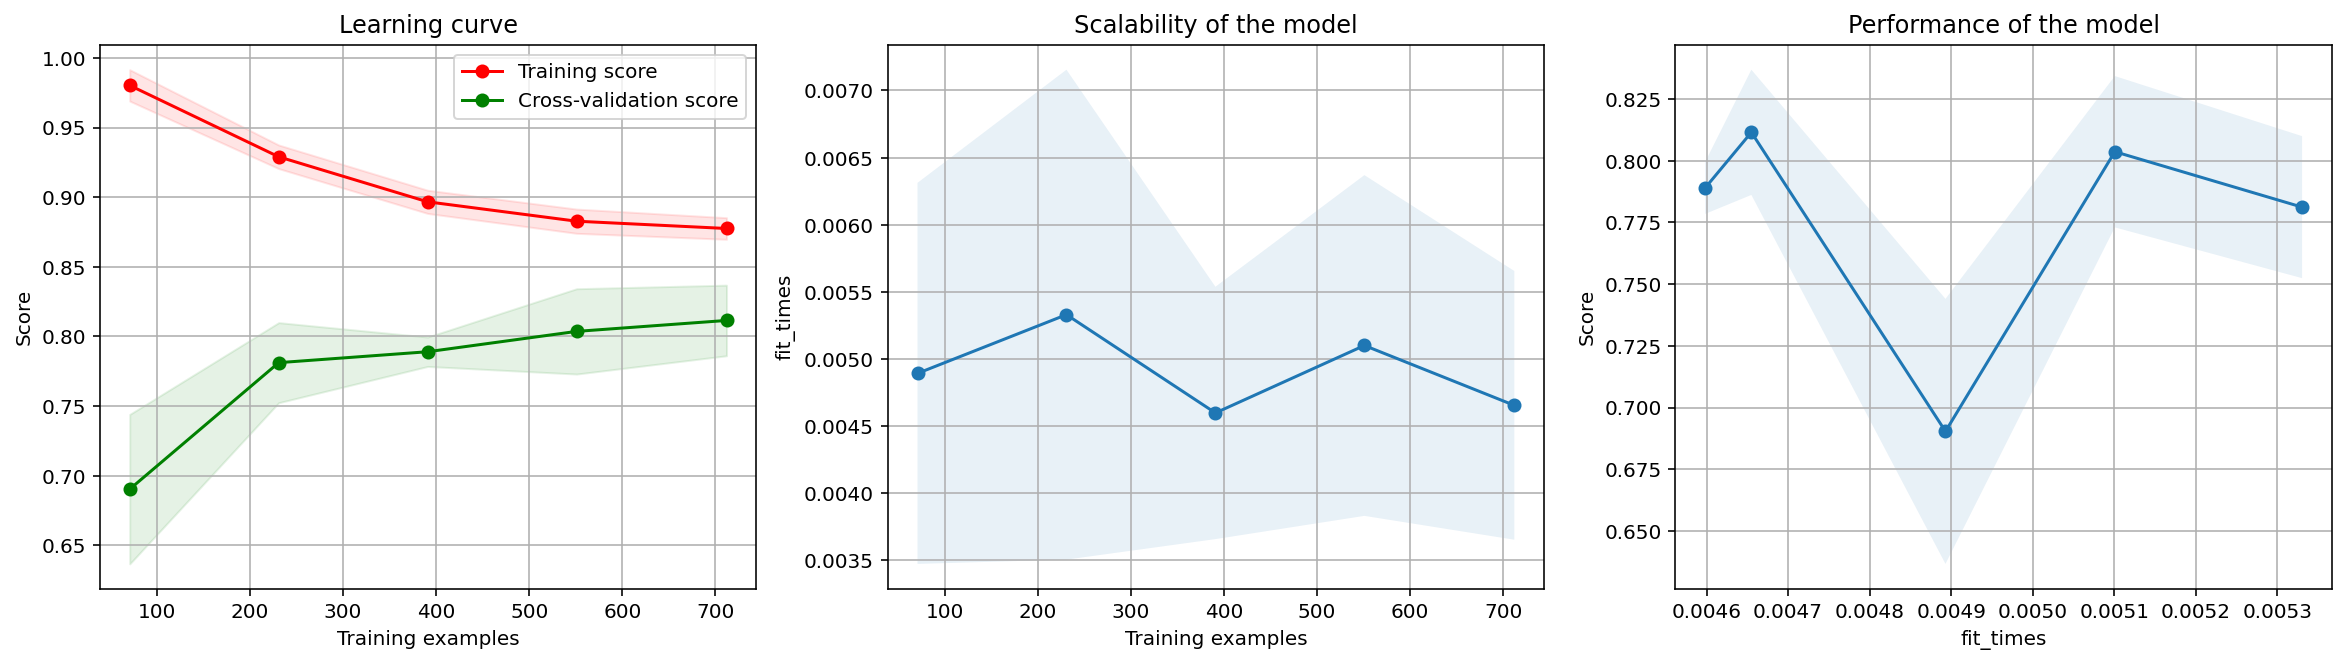

In [25]:
plot_learning_curve(clf_try, 'Learning curve', X, y)

* C'è un evidente gap fra quello che succede fra il validation sample e i dati di training, quindi siamo in una situazione di overfit

* La prima cosa che posso fare è ridurre il numero di nodi dell'albero. Provo a stimare dei nuovi parametri diminuendo il numero di nodi

clf score = 0.7932960893854749
clf best parameters = {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_leaf_nodes': 5}


<AxesSubplot:xlabel='param_clf__criterion', ylabel='param_clf__max_depth'>

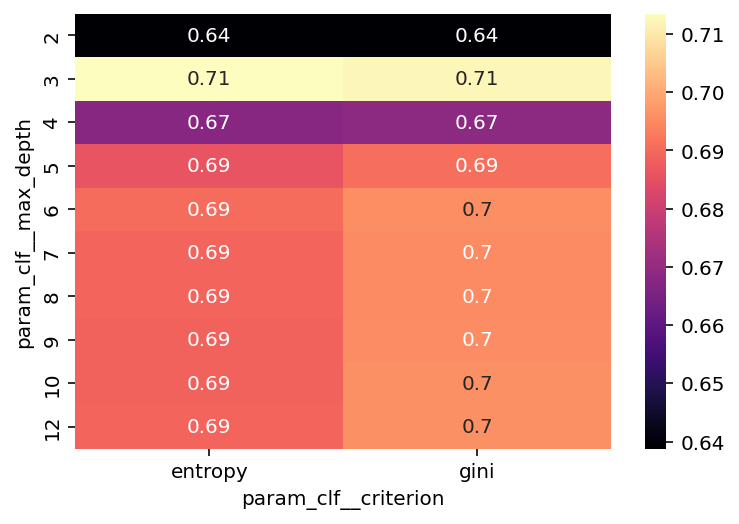

In [26]:
# quindi cambio i parametri
max_leaf_nodes= [i for i in range(2,20)]

#
parameters = dict(clf__criterion=criterion,clf__max_depth=max_depth,clf__max_leaf_nodes=max_leaf_nodes)

grid2 = GridSearchCV(pipe, parameters, scoring='f1') 
grid2.fit(X_train,y_train)
print('clf score =', grid2.best_estimator_.score(X_test, y_test))
print('clf best parameters =', grid2.best_params_)

 

hmknn = pd.pivot_table(pd.DataFrame(grid2.cv_results_),
                                    values='mean_test_score',
                                    index='param_clf__max_depth',
                                    columns='param_clf__criterion')

 

sns.heatmap(hmknn, cmap = 'magma', annot = True)

In [27]:
clf_best = DecisionTreeClassifier(max_depth=3,max_leaf_nodes=5,criterion='gini')
clf_best.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5)

In [28]:
y_pred_best=clf_best.predict(X_test)

In [29]:
np.count_nonzero(y_pred_best == y_test)

142

In [30]:
X_test.shape

(179, 4)

<module 'matplotlib.pyplot' from 'C:\\Users\\moham\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

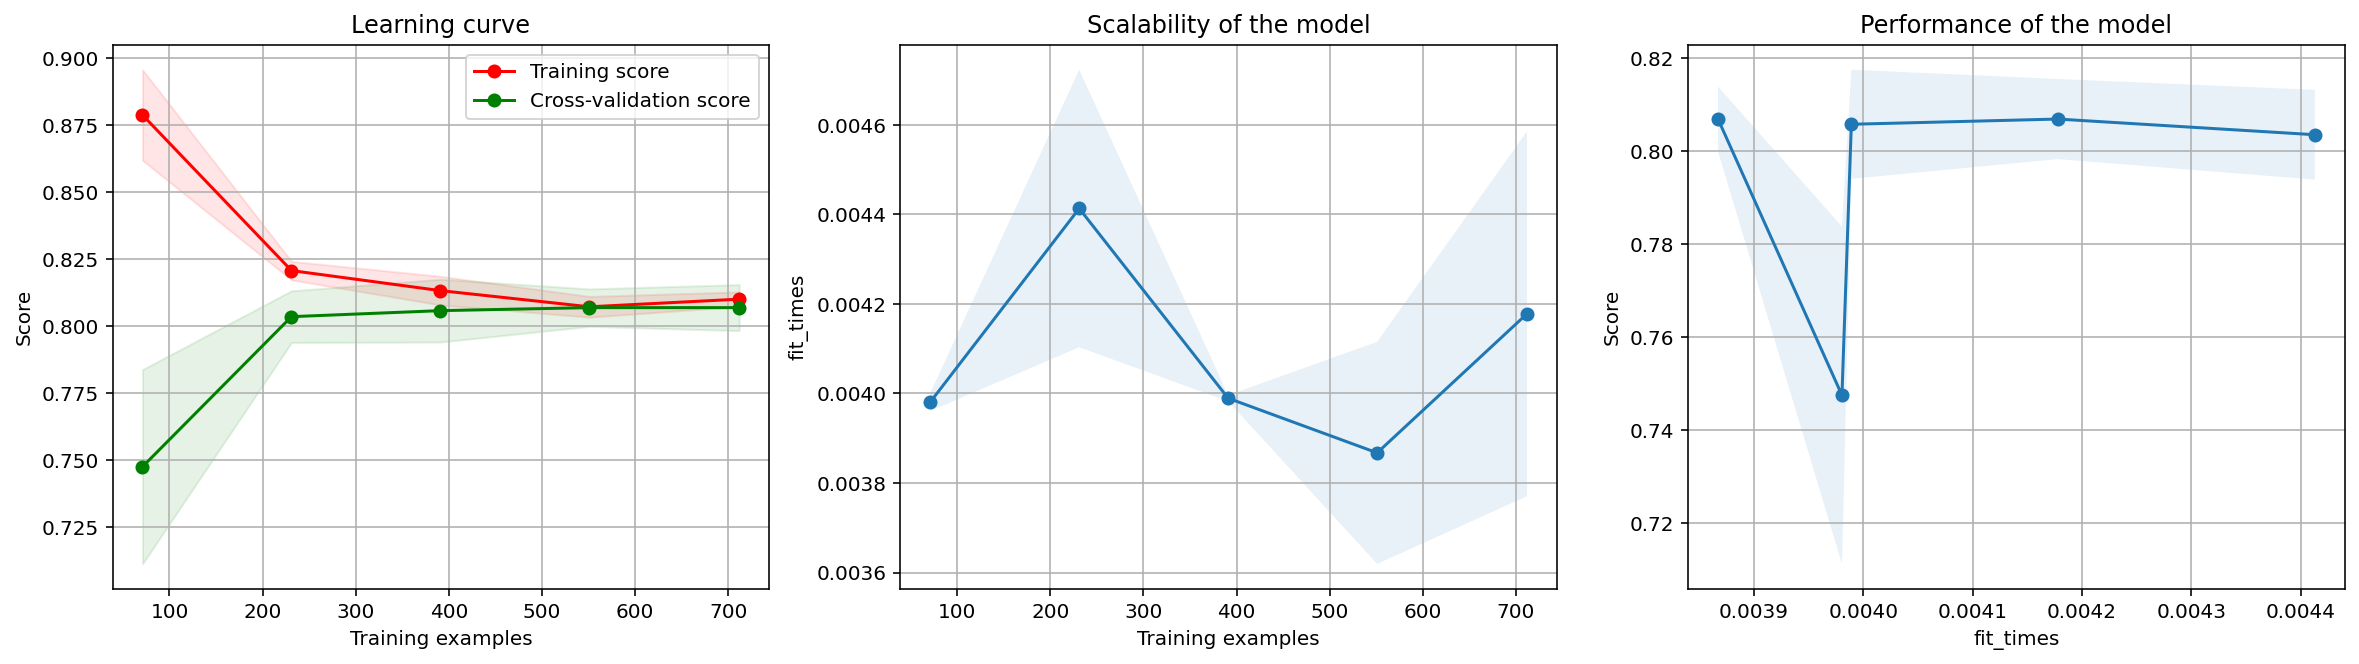

In [31]:
plot_learning_curve(clf_best, 'Learning curve', X, y)

* la situazione è molto migliorata, ora lo score del training e del validation sono comparabili, Faccio un print per vedere la struttura del nuovo albero

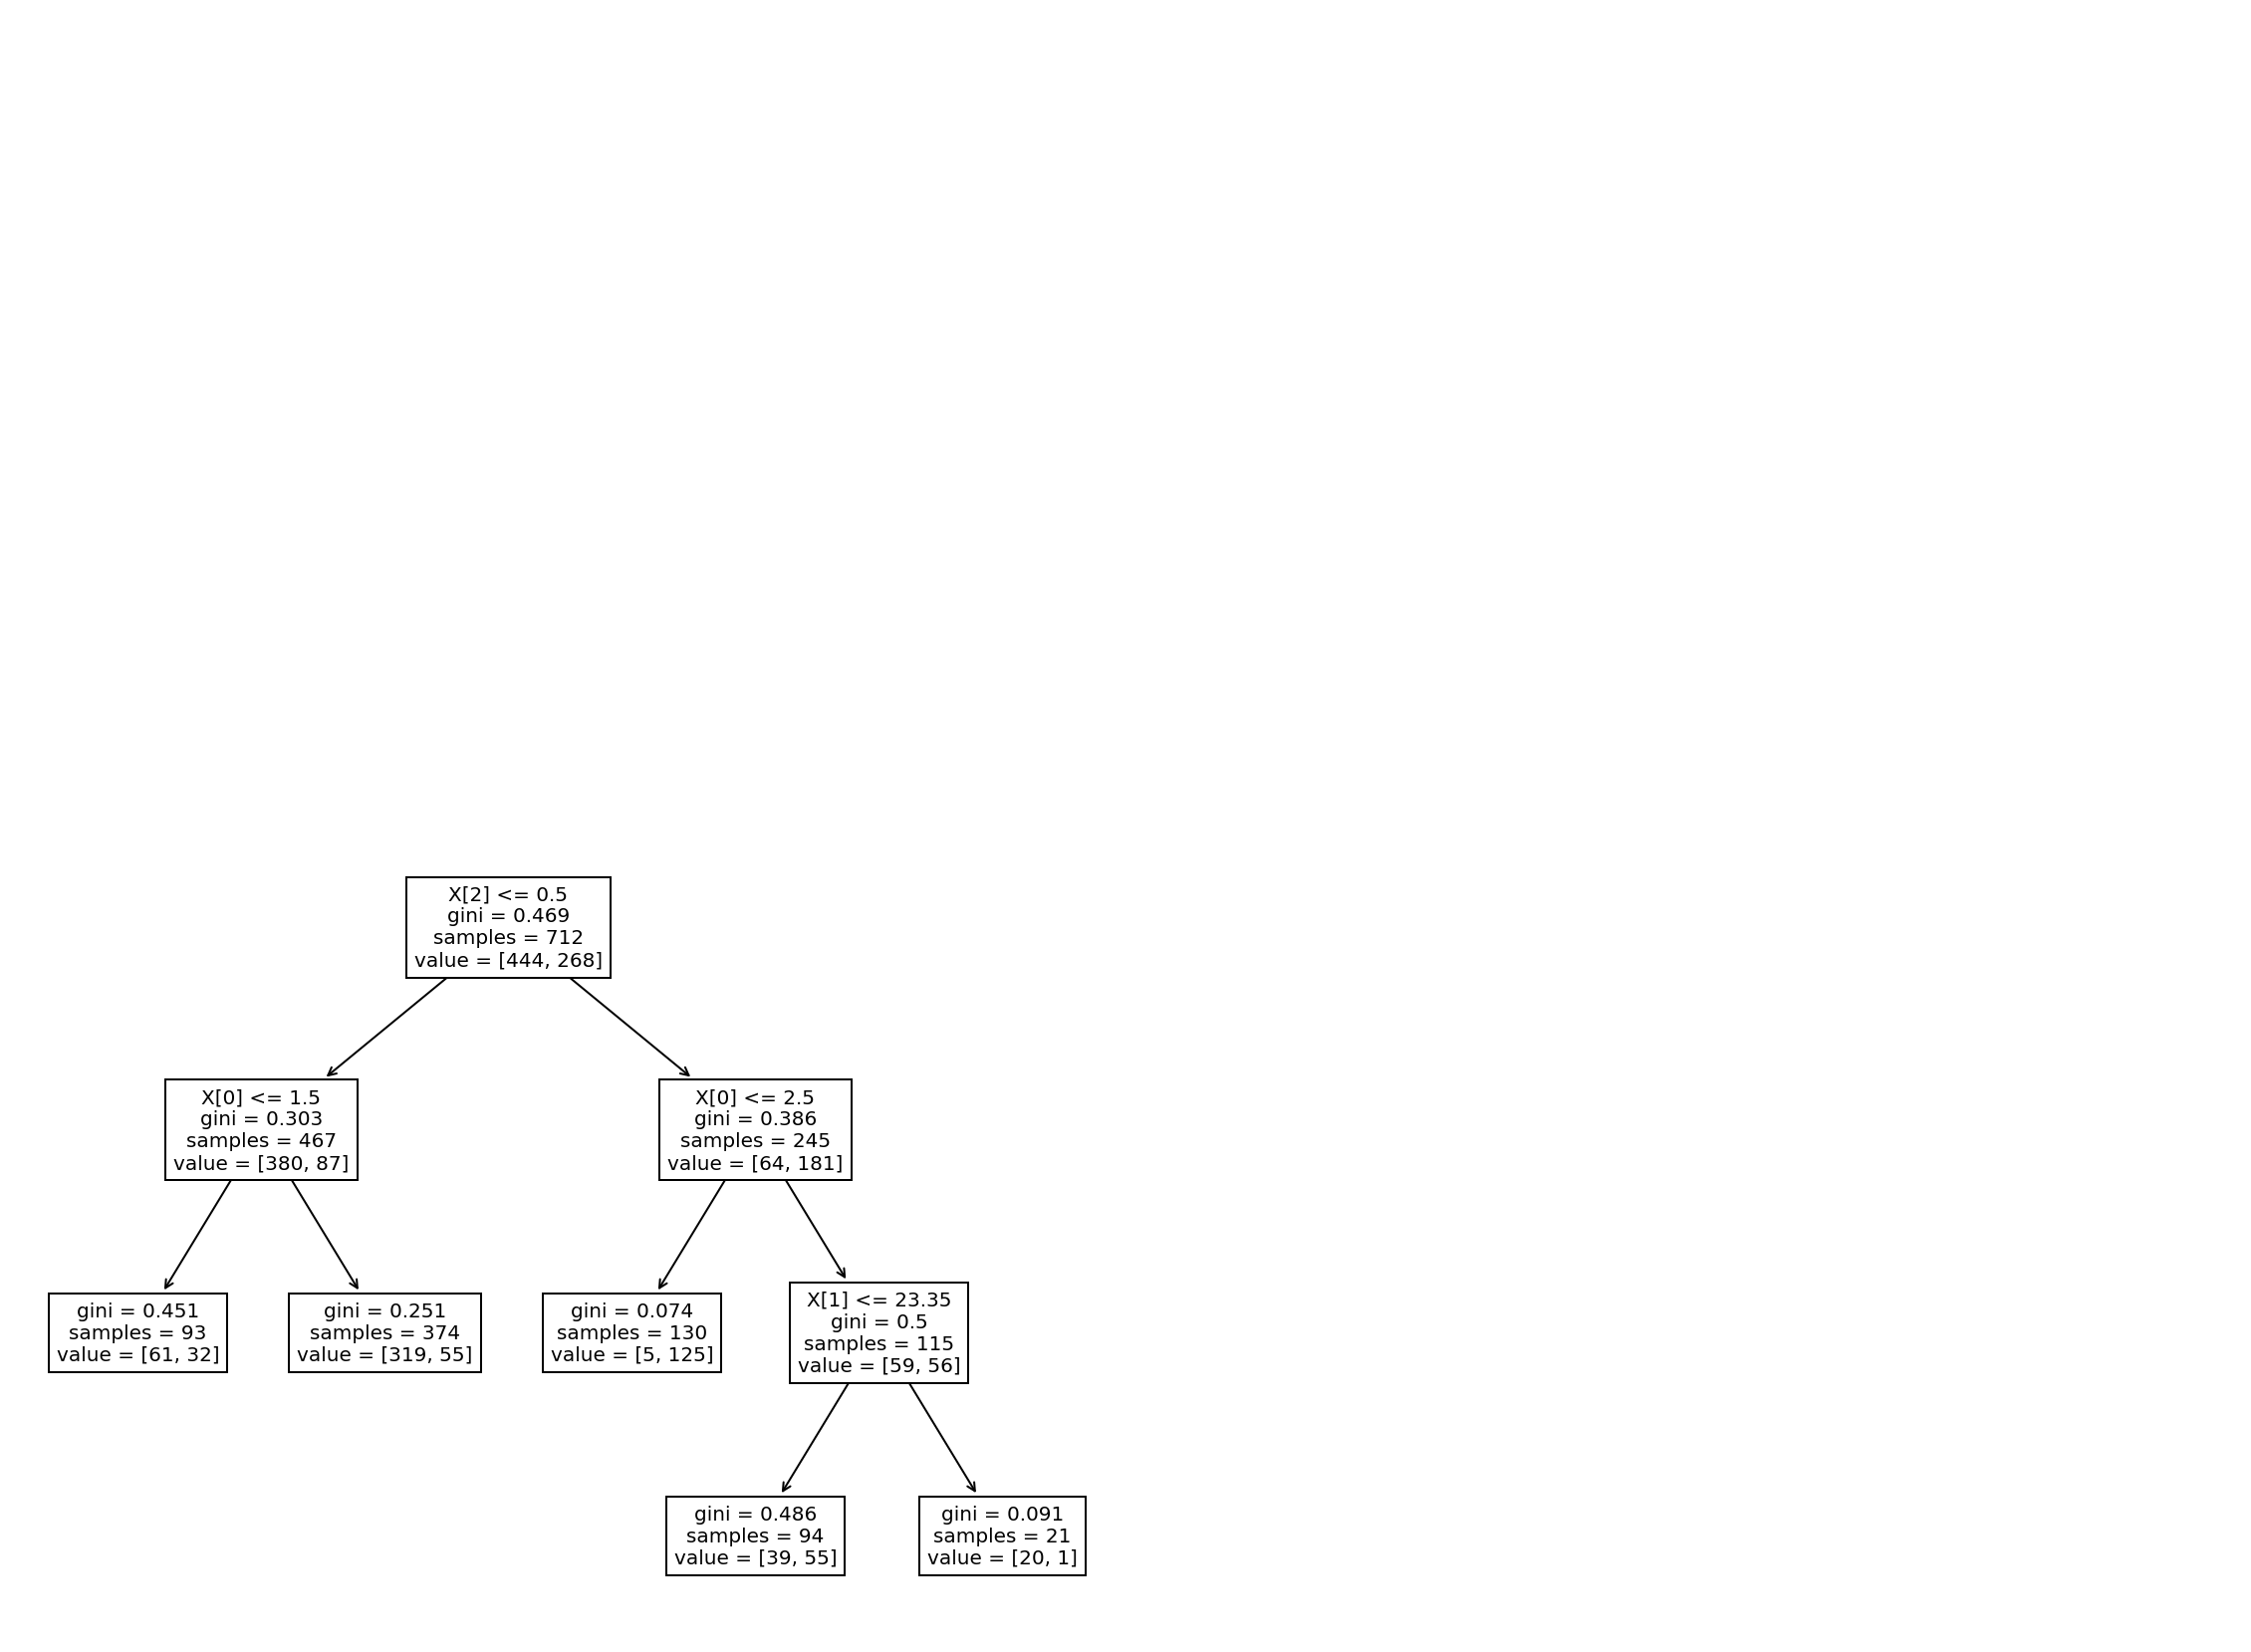

In [32]:
plt.figure(figsize=(20,15))
tree.plot_tree(clf_best, fontsize= 10);